<a href="https://colab.research.google.com/github/gowthambalachandhiran/PytorchExamples/blob/main/CNN_and_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3
7. Exercises

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
num_classes = 10

In [ ]:
batch_size = 4

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
5


In [ ]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [ ]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

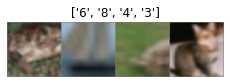

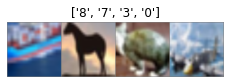

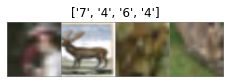

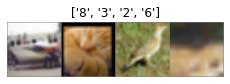

In [ ]:
for i in range(4):
    show_batch_images(trainloader)

## Creating VGG-16

https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html

In [ ]:
from torchvision import models

In [ ]:
vgg = models.vgg16_bn()

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
#Printing the first layer of the feature layer
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=10, bias=True)


In [ ]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
print(mod_classifier)
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]
[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [ ]:
#Attaching classifier as last layer
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Train CIFAR10

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.38
Iteration: 100/3125, Loss: 2.37
Iteration: 200/3125, Loss: 2.09
Iteration: 300/3125, Loss: 2.23
Iteration: 400/3125, Loss: 2.09
Iteration: 500/3125, Loss: 2.31
Iteration: 600/3125, Loss: 2.29
Iteration: 700/3125, Loss: 2.04
Iteration: 800/3125, Loss: 2.23
Iteration: 900/3125, Loss: 2.32
Iteration: 1000/3125, Loss: 2.02
Iteration: 1100/3125, Loss: 2.44
Iteration: 1200/3125, Loss: 2.02
Iteration: 1300/3125, Loss: 2.14
Iteration: 1400/3125, Loss: 2.17
Iteration: 1500/3125, Loss: 2.23
Iteration: 1600/3125, Loss: 2.05
Iteration: 1700/3125, Loss: 2.09
Iteration: 1800/3125, Loss: 2.24
Iteration: 1900/3125, Loss: 2.25
Iteration: 2000/3125, Loss: 2.22
Iteration: 2100/3125, Loss: 2.01
Iteration: 2200/3125, Loss: 2.31
Iteration: 2300/3125, Loss: 2.00
Iteration: 2400/3125, Loss: 1.84
Iteration: 2500/3125, Loss: 1.61
Iteration: 2600/3125, Loss: 2.20
Iteration: 2700/3125, Loss: 2.15
Iteration: 2800/3125, Loss: 2.31
Iteration: 2900/3125, Loss: 1.88
Iteration: 3000/3125, 

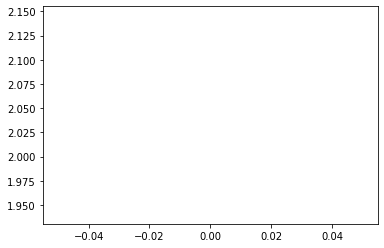

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()

### Freeze layers of Convolutional Operations

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.30
Iteration: 100/3125, Loss: 1.65
Iteration: 200/3125, Loss: 2.89
Iteration: 300/3125, Loss: 1.92
Iteration: 400/3125, Loss: 1.58
Iteration: 500/3125, Loss: 1.53
Iteration: 600/3125, Loss: 1.60
Iteration: 700/3125, Loss: 1.65
Iteration: 800/3125, Loss: 2.17
Iteration: 900/3125, Loss: 2.38
Iteration: 1000/3125, Loss: 2.09
Iteration: 1100/3125, Loss: 2.03
Iteration: 1200/3125, Loss: 1.37
Iteration: 1300/3125, Loss: 1.48
Iteration: 1400/3125, Loss: 1.09
Iteration: 1500/3125, Loss: 1.99
Iteration: 1600/3125, Loss: 1.41
Iteration: 1700/3125, Loss: 3.39
Iteration: 1800/3125, Loss: 2.30
Iteration: 1900/3125, Loss: 2.21
Iteration: 2000/3125, Loss: 2.58
Iteration: 2100/3125, Loss: 1.30
Iteration: 2200/3125, Loss: 1.66
Iteration: 2300/3125, Loss: 1.94
Iteration: 2400/3125, Loss: 1.81
Iteration: 2500/3125, Loss: 2.27
Iteration: 2600/3125, Loss: 1.77
Iteration: 2700/3125, Loss: 2.04
Iteration: 2800/3125, Loss: 2.08
Iteration: 2900/3125, Loss: 1.50
Iteration: 3000/3125, 

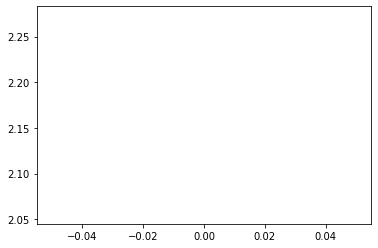

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

### With model copies

In [ ]:
import copy

In [ ]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 2.50
Iteration: 0/3125, Loss: 2.50
Min loss 1.68
Min loss 1.13
Min loss 1.01
Min loss 1.00
Iteration: 100/3125, Loss: 2.15
Min loss 0.90
Min loss 0.78
Iteration: 200/3125, Loss: 0.89
Iteration: 300/3125, Loss: 2.38
Min loss 0.54
Iteration: 400/3125, Loss: 2.71
Iteration: 500/3125, Loss: 2.19
Iteration: 600/3125, Loss: 1.62
Iteration: 700/3125, Loss: 1.58
Iteration: 800/3125, Loss: 1.26
Iteration: 900/3125, Loss: 1.80
Iteration: 1000/3125, Loss: 1.97
Min loss 0.53
Iteration: 1100/3125, Loss: 2.24
Iteration: 1200/3125, Loss: 2.48
Iteration: 1300/3125, Loss: 1.94
Iteration: 1400/3125, Loss: 2.45
Iteration: 1500/3125, Loss: 3.08
Iteration: 1600/3125, Loss: 2.04
Iteration: 1700/3125, Loss: 1.89
Iteration: 1800/3125, Loss: 2.85
Iteration: 1900/3125, Loss: 2.01
Iteration: 2000/3125, Loss: 2.61
Iteration: 2100/3125, Loss: 1.32
Iteration: 2200/3125, Loss: 1.19
Iteration: 2300/3125, Loss: 1.80
Iteration: 2400/3125, Loss: 2.67
Iteration: 2500/3125, Loss: 1.71
Iteration: 2600/3125, Loss: 

In [ ]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

43.938 43.77


## ResNet Model

https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html

In [ ]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
print(resnet)

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

In [ ]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

In [ ]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

## Inception Model

https://pytorch.org/docs/master/_modules/torchvision/models/inception.html

In [ ]:
inception = models.inception_v3(pretrained=True)

In [ ]:
print(inception)

In [ ]:
for param in inception.parameters():
    param.requires_grad = False

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

In [ ]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

In [ ]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [ ]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

## Exercises

In [ ]:
trainset = torchvision.datasets.STL10(root='./data', split = 'train', 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.STL10(root='./data', split = 'test', 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified



1. Try out the STL10 datasets

2. Try out another model - SqueezeNet

3. Try training multiple layers and not just the last one

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Trying the Squeezenet

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[5].item())

torch.Size([10, 3, 224, 224])
torch.Size([3, 224, 224])
9


In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'squeezenet1_0', pretrained=True)
# or
# model = torch.hub.load('pytorch/vision:v0.6.0', 'squeezenet1_1', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
#Attaching a classifier on top sequeezenet. We are first flatenning it and then feeding it to squeeze net
## How many In_channels are there for the conv layer
in_ftrs = model.classifier[1].in_channels
print(in_ftrs)
## How many Out_channels are there for the conv layer
out_ftrs = model.classifier[1].out_channels
print(out_ftrs)

512
1000


In [ ]:
## Converting a sequential layer to list of layers 
features = list(model.classifier.children())
print(features)

[Dropout(p=0.5, inplace=False), Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1)), ReLU(inplace=True), AdaptiveAvgPool2d(output_size=(1, 1))]


In [ ]:
## Changing the conv layer to required dimension
n_class=10
features[1] = nn.Conv2d(in_ftrs, n_class,kernel_size=(1,1),stride=(1,1))
## Changing the pooling layer as per the architecture output
features[3] = nn.AvgPool2d(12, stride=1)
## Making a container to list all the layers
model.classifier = nn.Sequential(*features)
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
squeezenet = model.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.003)

In [ ]:
import time

In [ ]:
def evaluation_squeeze(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 3.40
Iteration: 0/5000, Loss: 3.40
Min loss 2.53
Min loss 2.12
Min loss 1.95
Min loss 1.93
Min loss 1.83
Min loss 1.82
Min loss 1.80
Min loss 1.67
Min loss 1.57
Iteration: 100/5000, Loss: 2.08
Min loss 1.47
Min loss 1.46
Min loss 1.38
Min loss 1.28
Iteration: 200/5000, Loss: 2.03
Min loss 1.15
Min loss 1.08
Iteration: 300/5000, Loss: 1.66
Iteration: 400/5000, Loss: 1.53
Min loss 1.08
Epoch: 0/7, Test acc: 41.64, Train acc: 40.23
Iteration: 0/5000, Loss: 1.38
Min loss 1.07
Min loss 1.02
Min loss 0.86
Iteration: 100/5000, Loss: 2.16
Min loss 0.82
Iteration: 200/5000, Loss: 1.18
Iteration: 300/5000, Loss: 1.11
Min loss 0.68
Iteration: 400/5000, Loss: 1.15
Min loss 0.60
Epoch: 1/7, Test acc: 48.54, Train acc: 46.17
Iteration: 0/5000, Loss: 1.04
Iteration: 100/5000, Loss: 1.59
Iteration: 200/5000, Loss: 1.62
Iteration: 300/5000, Loss: 0.94
Min loss 0.56
Iteration: 400/5000, Loss: 1.51
Epoch: 2/7, Test acc: 51.98, Train acc: 50.89
Iteration: 0/5000, Loss: 1.13
Iteration: 100/5000, L

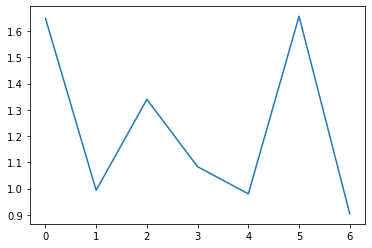

In [ ]:
loss_epoch_arr = []
max_epochs = 7

min_loss = 5
batch_size = 10
n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs= squeezenet(inputs)
        loss = loss_fn(outputs, labels) 
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(squeezenet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,evaluation_squeeze(trainloader, squeezenet),evaluation_squeeze(testloader, squeezenet)))
    
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
squeezenet.load_state_dict(best_model)
print(evaluation_squeeze(trainloader, squeezenet), evaluation_squeeze(testloader, squeezenet))

57.54 55.7625


Creating a model where I will only be updating the weight for last layer

In [ ]:
#Freezing all top layers
for param in model.features.parameters():
  param.requires_grad = False


In [ ]:
"""The statement below would confirm if its frozen to avoid parameter update"""

#for param in model.features.parameters():
#print(param.requires_grad)

'The statement below would confirm if its frozen to avoid parameter update'

In [ ]:
squeezenet = model.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.003)

Min loss 1.27
Iteration: 0/5000, Loss: 1.27
Min loss 1.16
Min loss 1.15
Min loss 0.79
Min loss 0.69
Min loss 0.51
Iteration: 100/5000, Loss: 0.95
Iteration: 200/5000, Loss: 0.75
Min loss 0.51
Min loss 0.43
Iteration: 300/5000, Loss: 0.65
Iteration: 400/5000, Loss: 0.91
Epoch: 0/7, Test acc: 60.60, Train acc: 58.36
Iteration: 0/5000, Loss: 0.71
Iteration: 100/5000, Loss: 1.12
Min loss 0.40
Min loss 0.39
Iteration: 200/5000, Loss: 1.09
Iteration: 300/5000, Loss: 0.85
Iteration: 400/5000, Loss: 0.77
Epoch: 1/7, Test acc: 61.82, Train acc: 58.71
Iteration: 0/5000, Loss: 1.02
Iteration: 100/5000, Loss: 0.64
Iteration: 200/5000, Loss: 0.99
Iteration: 300/5000, Loss: 0.79
Min loss 0.34
Iteration: 400/5000, Loss: 1.56
Epoch: 2/7, Test acc: 60.58, Train acc: 57.51
Iteration: 0/5000, Loss: 1.23
Iteration: 100/5000, Loss: 0.56
Iteration: 200/5000, Loss: 1.12
Iteration: 300/5000, Loss: 1.40
Iteration: 400/5000, Loss: 1.13
Epoch: 3/7, Test acc: 61.26, Train acc: 59.23
Iteration: 0/5000, Loss: 1.04


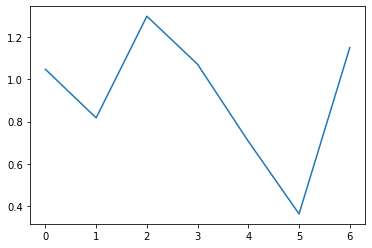

In [ ]:
loss_epoch_arr = []
max_epochs = 7

min_loss = 5
batch_size = 10
n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs= squeezenet(inputs)
        loss = loss_fn(outputs, labels) 
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(squeezenet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs,evaluation_squeeze(trainloader, squeezenet),evaluation_squeeze(testloader, squeezenet)))
    
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
squeezenet.load_state_dict(best_model)
print(evaluation_squeeze(trainloader, squeezenet), evaluation_squeeze(testloader, squeezenet))

62.68 58.55
